In [4]:
from utils.converters import df_to_XY
from utils.readers import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.tools as smt
from scipy.optimize import curve_fit
import statsmodels.stats.descriptivestats as std
from statsmodels.distributions.empirical_distribution import ECDF

## Read data
## Grouping M&A volume by month

In [29]:
def reconfigure_vol_df(df):
    df['Date'] = df['Date'].dt.to_period('M')
    out = {'date': [], 'vol': []}
    for y in range(2000, 2022):
        for m in range(1, 13):
            i = f"{y}-{m}"
            d = df[df['Date'] == i]
            out['date'].append(i)
            out['vol'].append(len(d))
    df = pd.DataFrame(data=out['vol'], index=out['date'], columns=['vol'])
    df.index.name = 'date'
    return df

In [30]:
"""Groups M&A transactions of UK being the acquirer by month"""
acquirer_uk = read_acquirer_uk()
acquirer_uk = reconfigure_vol_df(acquirer_uk)

In [31]:
"""Groups M&A transactions of UK being the target by month"""
target_uk= read_target_uk()
target_uk = reconfigure_vol_df(target_uk)

In [32]:
"""Net M&A volume"""
net_vol_monthly = target_uk + acquirer_uk

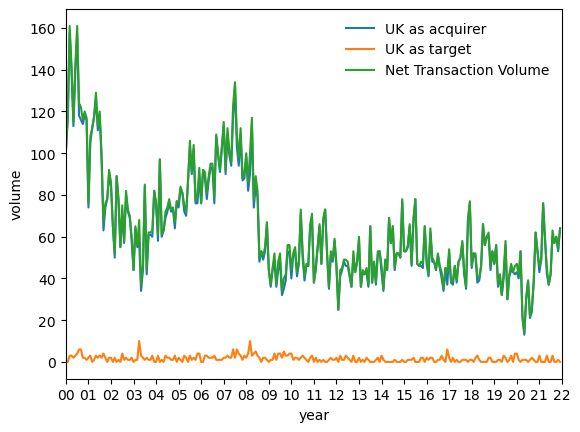

In [33]:
ax = plt.gca()
ax.plot(acquirer_uk.index.values.astype(str), acquirer_uk.vol, label='UK as acquirer')
ax.plot(target_uk.index.values.astype(str), target_uk.vol, label='UK as target')
ax.plot(net_vol_monthly.index.values.astype(str), net_vol_monthly.vol, label='Net Transaction Volume')
ax.set_xticks([])
ax.legend(frameon=False)
ax.set_xticks(ticks=range(0, 265, 12), labels=[str(i).zfill(2) for i in range(0, 23, 1)])
ax.set_xlim(0, 264)
ax.set_ylabel('volume')
ax.set_xlabel('year');

## Processing data by month

## Variables

In [34]:
until = '2022-01'
var_monthly = read_variable_monthly()
interest_rate = read_interest_rate()
interest_rate['Date'] = interest_rate['Date'].dt.to_period('M')
var_monthly['Date'] = var_monthly['Date'].dt.to_period('M')
var_monthly = var_monthly[var_monthly['Date'] < until]
interest_rate = interest_rate[interest_rate['Date'] < until]
var_monthly['vol'] = net_vol_monthly.vol.values
var_monthly['Interest_Rate'] = interest_rate['Interest_Rate']

res = {'EXUSUK': [], 'Interest_Rate': [], 'SMI': []}
for i in range(int(len(var_monthly)/3)):
    s = var_monthly[3*i: 3*(i+1)]
    res['EXUSUK'].append(s.EXUSUK.mean())
    res['Interest_Rate'].append(s['Interest_Rate'].mean())
    res['SMI'].append(s.SMI.mean())

## Main Regression
## First, regressed on historical observations from 2002 to 2016, before the Brexit. Then used trained results to forecast with a
## confidence level of 95% for periods from 2016 to 2021 assuming that Brexit did not happen.

In [35]:
"""To determine the effect the Brexit, we refer to the day of UK announcing its plan to exit the European Union as the separation date"""

x_index = ['EXUSUK', 'Interest_Rate', 'SMI']
y_index = ['vol']

start_from = '2002-01'
data = var_monthly[var_monthly.Date >= start_from]
data.reset_index(inplace=True, drop=True)
sep = '2016-6'
data_before = data[data.Date < sep]
data_after = data[data.Date > sep]

"""Regressing on historical transactions between Aug.2001 to June.2016"""
X_train, Y_train = df_to_XY(data_before, xkeys=x_index, ykeys=y_index)
X_train = sm.add_constant(X_train)

"""Regressing on historical transactions between June.2016 to Nov.2021"""
X_test, Y_test = df_to_XY(data_after, xkeys=x_index, ykeys=y_index)
X_test = sm.add_constant(X_test)

model_before = LinearRegression().fit(X_train, Y_train)
model_after = LinearRegression().fit(X_test, Y_test)

"""R square of model before and after the announcement of Brexit"""
model_before.score(X_train, Y_train), model_after.score(X_test, Y_test)

(0.617764976094516, 0.2318908533369991)

In [36]:
model_before.coef_

array([[ 0.        , 22.12368281,  9.46650448,  0.03523657]])

In [37]:
data

,Date,EXUSUK,Interest_Rate,SMI,vol
0,2002-01,1.4322,4.9171,962.025,86
1,2002-02,1.4227,4.9251,924.759,65
2,2002-03,1.4230,5.2202,927.846,52
3,2002-04,1.4429,5.2331,959.587,89
4,2002-05,1.4598,5.2689,946.755,78
...,...,...,...,...,...
235,2021-08,1.3797,0.6440,1154.280,63
236,2021-09,1.3732,0.8023,1150.933,57
237,2021-10,1.3701,1.0830,1113.011,60
238,2021-11,1.3463,0.9394,1167.690,54


In [38]:
new_T = pd.DataFrame(var_monthly.EXUSUK)
new_T['smi'] = var_monthly.SMI
new_T['interest_rate'] = var_monthly.Interest_Rate
t_corr = new_T.corr(method='pearson')
t_corr

,EXUSUK,smi,interest_rate
EXUSUK,1.000000,0.504034,0.699603
smi,0.504034,1.000000,0.086093
interest_rate,0.699603,0.086093,1.000000


To evaluate the influence of Brexit, which happened in June of 2016, we divide the historical dataset into two parts by the event of Brexit: `X_train` and `X_text` for variables, and `Y_train` and `Y_test` for M&A volume, respectively. For each dataset, the OLS is adopted to build the model. In other words, the model before Brexit, named `model_before` is trained by the dateset before 2016 June, i.e., `X_train`. Hence, the use of the trained model (`model_before`) with the given `X_test` yields its own prediction, called `Y_test_pred_model_before`,  that is assumed without the influence of Brexit. Finally, calculating the percentage error between `Y_test_pred_model_before` and `Y_test` is able to tell us how much the M&A volume is influenced by Brexit.

Of course, since we have `X_text` and `Y_test`, we are also able to run the OLS on it. Consequently, the model, called `model_after` is introduced, which should have the error mean close to zero by the OLS definition. Then we expect to see that the percentage error should be close to zero as well.

The cell below reconfigure the data to be able to process by the OLS. Also, the figure shows the OLS model, compared to the data.

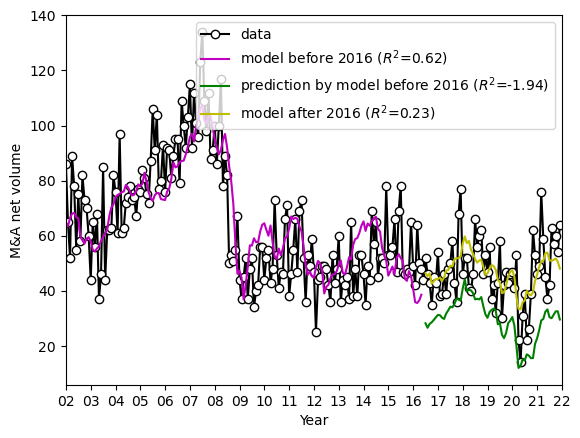

In [39]:
ax = plt.gca()

x_data = data.Date.astype(str)
ax.plot(x_data, data.vol, marker='o', color='k', mfc='white', ls='-', label='data')

Y_train_pred = model_before.predict(X_train)
x_data_before = data_before.index
r = r2_score(Y_train, Y_train_pred,)
ax.plot(x_data_before, Y_train_pred, color='m',
        label=f'model before 2016 ($R^2$={round(r, 2)})')

x_data_after = data_after.index
Y_test_pred = model_before.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='g',
        label=f'prediction by model before 2016 ($R^2$={round(r, 2)})')


"""Using model based on data before June.2016 to predict for 2016 - 2021"""
Y_test_pred = model_after.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='y',
        label=f'model after 2016 ($R^2$={round(r, 2)})')

# ax.axvline(65, ls='--', color='gray')
plt.xticks(ticks=range(0, 241, 12), labels=[str(i).zfill(2) for i in range(2, 23, 1)])
ax.set_xlim(0, 240)
ax.set_ylabel('M&A net volume')
ax.set_xlabel('Year')
# ax.set_ylim(0, -500)
ax.legend(loc=0, frameon=True);

## More detailed graph for comparisons b/w prediction (CL=95%) made by trained model & actual observations

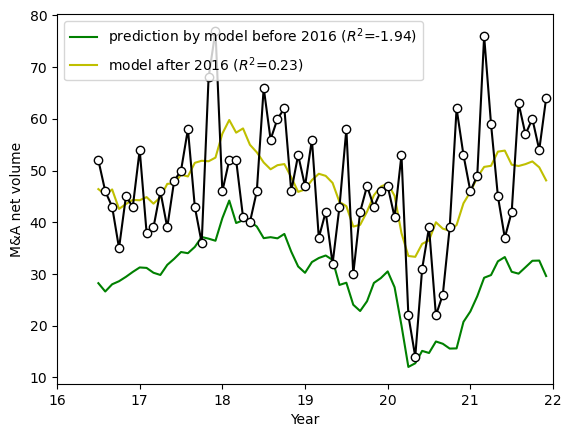

In [40]:
ax = plt.gca()

x_data_after = data_after.index
Y_test_pred = model_before.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='g',
        label=f'prediction by model before 2016 ($R^2$={round(r, 2)})')


"""Using model based on data before June.2016 to predict for 2016 - 2021"""
Y_test_pred = model_after.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='y',
        label=f'model after 2016 ($R^2$={round(r, 2)})')


ax.plot(x_data_after, Y_test, marker='o', color='k', mfc='white')
ax.set_ylabel('M&A net volume')
ax.set_xlabel('Year')
plt.xticks(ticks=range(168, 241, 12), labels=[str(i).zfill(2) for i in range(16, 23, 1)])
ax.set_xlim(168, 240)
ax.legend(loc=0, frameon=True);

## Residual plot of differences between prediction & observations

Text(0.5, 0, 'Data')

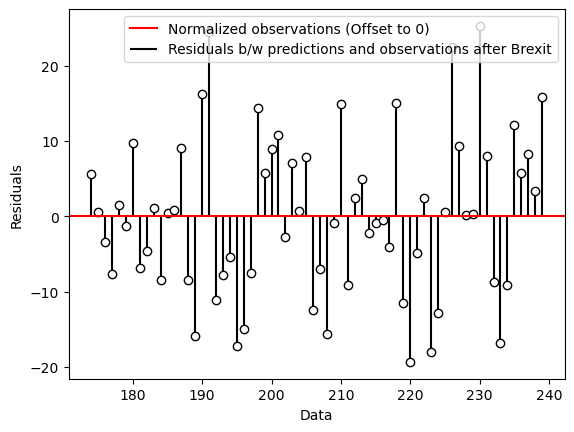

In [41]:
difference = Y_test_pred - Y_test
difference *= -1
zeros = np.zeros(len(difference))
ax = plt.gca()
ax.plot(data_after.index, difference, ls='', color='k', marker='o', mfc='w', zorder=2)
ax.axhline(0, ls='-', color='r', label='Normalized observations (Offset to 0)')
ax.vlines(data_after.index, ymin=zeros, ymax=difference, colors='k', zorder=1, label=f'Residuals b/w predictions and observations after Brexit')
ax.legend(loc=0, frameon=True)
ax.set_ylabel('Residuals')
ax.set_xlabel('Data')

## Fitting residuals with Gaussian distribution (This is reasonable even though it is not a bell curve,
## I only did it to see the distribution. No need to include in the appendix)

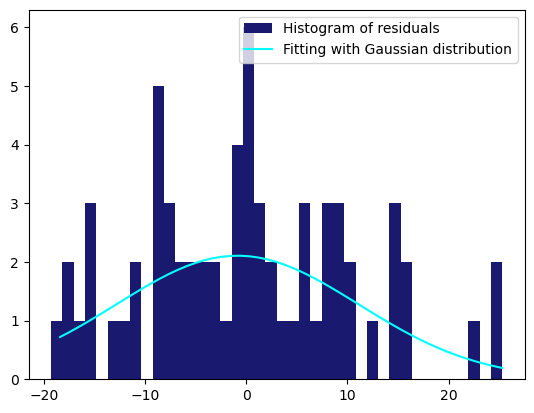

In [42]:
xdata = difference
ydata, xdata = np.histogram(xdata, bins=50)
xdata = xdata[1:]

def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

params, _ = curve_fit(gauss, xdata, ydata)

fit_y = gauss(xdata, *params)

ax = plt.gca()
ax.hist(difference, bins=40, color='midnightblue', label='Histogram of residuals')
ax.plot(xdata, fit_y, ls='-', color='aqua', label='Fitting with Gaussian distribution')
ax.legend(loc=0, frameon=True)

Instead of using the mean square error, we simply use the percentage error given as

$$
\text{ER} = \frac{Y_{test} - \hat{Y}_{test}^{before}}{Y_{test}}.
$$
This way we can learn the direction of the prediction, either over-estimation or under-estimation.

In [43]:
Y_test_pred_model_before = model_before.predict(X_test)
Y_test_pred_model_after = model_after.predict(X_test)

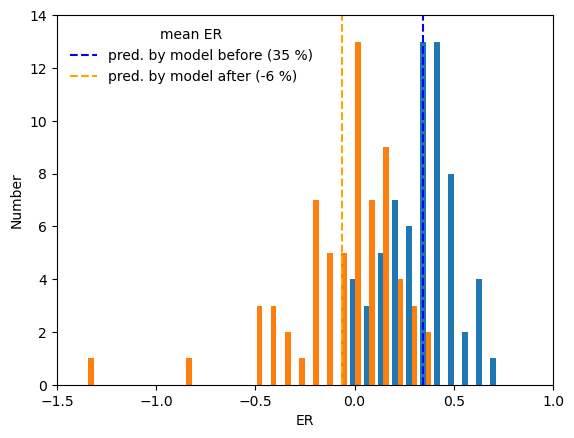

In [44]:
error_test_model_before = (Y_test - Y_test_pred_model_before) / Y_test
error_test_model_after = (Y_test - Y_test_pred_model_after) / Y_test
ax = plt.gca()

ax.hist([error_test_model_before.reshape(-1), error_test_model_after.reshape(-1)], bins=30)
ax.axvline(error_test_model_before.mean(), color='b', ls='--',
           label=f'pred. by model before ({round(error_test_model_before.mean()*100)} %)')
ax.axvline(error_test_model_after.mean(), color='orange', ls='--',
           label=f'pred. by model after ({round(error_test_model_after.mean()*100)} %)')

ax.set_xlabel('ER')
ax.set_ylabel('Number')
ax.set_xlim(-1.5, 1)
ax.set_ylim(0, 14)
ax.legend(frameon=False, title='mean ER')

The figure above shows that the `model_before` underestimated the M&A volume by 35%. it alternatively says that Brexit increased the M&A volume from within UK to overseas by 35%. This is primarily because that the number of foreign companies using direct investment was so small that it was negligible.

## Model before announcement of Brexit

In [45]:
"""Summary of model based on historical data before 2016"""
multi_model_before = sm.OLS(Y_train, X_train).fit()
multi_model_before.summary(xname=['Constant', 'Spot_Rate', 'Interest_Rate', 'SMI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     91.05
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           4.19e-35
Time:                        16:33:41   Log-Likelihood:                -694.33
No. Observations:                 173   AIC:                             1397.
Df Residuals:                     169   BIC:                             1409.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -47.2305     12.210     -3.868      0.000     -71.334     -23.127
Spot_Rate        22.1237     12.956      1.708      0.090      -3.453      47.700
Interest_Rate     9.4665      1.425      6.641      0.000       6.653      12.280
SMI               0.0352      0.008      4.617      0.000       0.020       0.050
==============================================================================
Omnibus:                        2.102   Durbin-Watson:                   1.415
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.808
Skew:                           0.126   Prob(JB):                        0.405
Kurtosis:                       2.567   Cond. No.                     1.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
## Forecast with alpha=0.5
pred = multi_model_before.get_prediction(X_test)
summary_table = pred.summary_frame(alpha=0.32)
Y_test_pred_005_lower = summary_table['mean_ci_lower']
Y_test_pred_005_upper = summary_table['mean_ci_upper']

## Residual plot of the fitted model (the one before Brexit 2016)
## So we see that the residuals are normally distributed with a 0 mean.

Text(0.5, 0, 'Data')

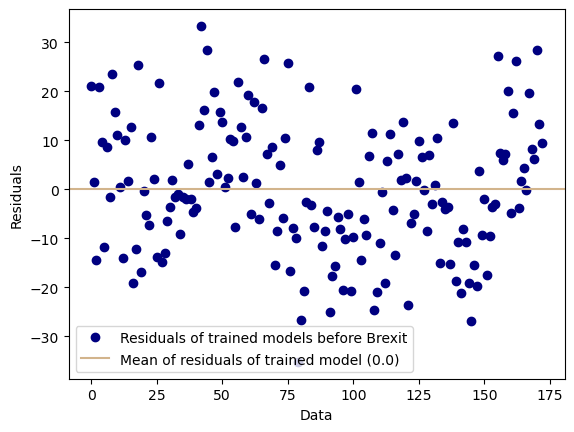

In [47]:
ax = plt.gca()
ax.plot(data_before.index, multi_model_before.resid, ' ', marker='o', label=f'Residuals of trained models before Brexit', color='navy')
ax.axhline(multi_model_before.resid.mean(), label=f'Mean of residuals of trained model ({abs(multi_model_before.resid.mean().round(2))})', color='tan')
ax.legend(loc=0, frameon=True)
ax.set_ylabel('Residuals')
ax.set_xlabel('Data')

In [28]:
from scipy.optimize import curve_fit

## Residuals of the model before Brexit fitted with Gaussian distribution

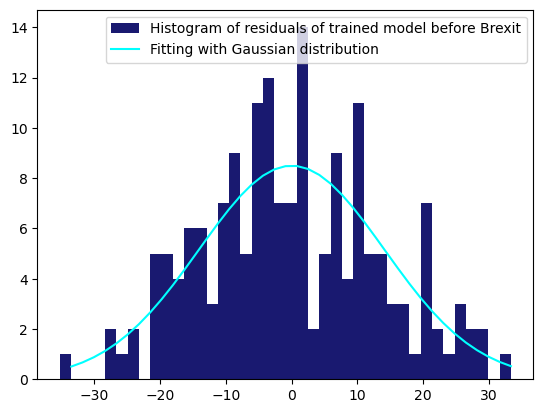

In [48]:
xdata = multi_model_before.resid
ydata, xdata = np.histogram(xdata, bins=40)
xdata = xdata[1:]

def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

params, _ = curve_fit(gauss, xdata, ydata)

fit_y = gauss(xdata, *params)

ax = plt.gca()
ax.hist(multi_model_before.resid, bins=40, color='midnightblue', label='Histogram of residuals of trained model before Brexit')
ax.plot(xdata, fit_y, ls='-', color='aqua', label='Fitting with Gaussian distribution')
ax.legend(loc=0, frameon=True)

## Detailed comparison b/w prediction with 95% confidence interval, and the actual observations.
## The banded region is the upper and lower mean of the forecast with 95% CL.

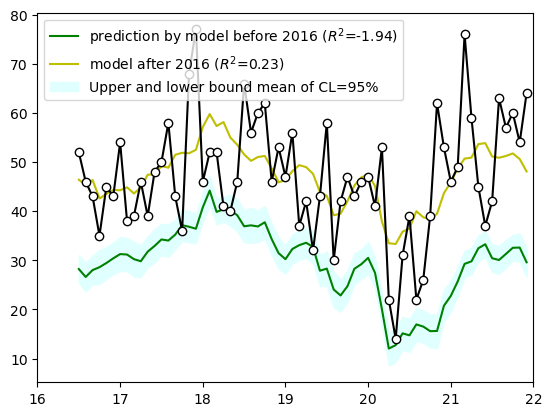

In [49]:
ax = plt.gca()

x_data_after = data_after.index
Y_test_pred = model_before.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='g',
        label=f'prediction by model before 2016 ($R^2$={round(r, 2)})')


"""Using model based on data before June.2016 to predict for 2016 - 2021"""
Y_test_pred = model_after.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='y',
        label=f'model after 2016 ($R^2$={round(r, 2)})')

# ax.plot(x_data_after, Y_test_pred_005_lower, color='r', ls='--')
# ax.plot(x_data_after, Y_test_pred_005_upper, color='b', ls='--')

ax.fill_between(x_data_after, Y_test_pred_005_lower, Y_test_pred_005_upper, color='lightcyan', label='Upper and lower bound mean of CL=95%')

ax.plot(x_data_after, Y_test, marker='o', color='k', mfc='white')
plt.xticks(ticks=range(168, 241, 12), labels=[str(i).zfill(2) for i in range(16, 23, 1)])
ax.set_xlim(168, 240)
ax.legend(loc=0, frameon=True);

In [32]:
# multi_model_before.get_prediction(X_test)
# diff = summary_table.obs_ci_lower - summary_table.mean_ci_lower
# diff2 = summary_table.mean_ci_upper - summary_table.obs_ci_upper
# diff
# pred.prediction_results

In [50]:
mean_upper = summary_table.mean_ci_upper
mean_lower = summary_table.mean_ci_lower
fitted_upper = summary_table.obs_ci_upper
fitted_lower = summary_table.obs_ci_lower
# plt.plot(mean_upper, 'r--', lw=2)
# plt.plot(mean_lower,'r--', lw=2)
# plt.plot(fitted_upper, '-', lw=2, color='blue')
# plt.plot(fitted_lower, '-', lw=2, color='blue')
# plt.plot(x_data_after)

eval_env: 1


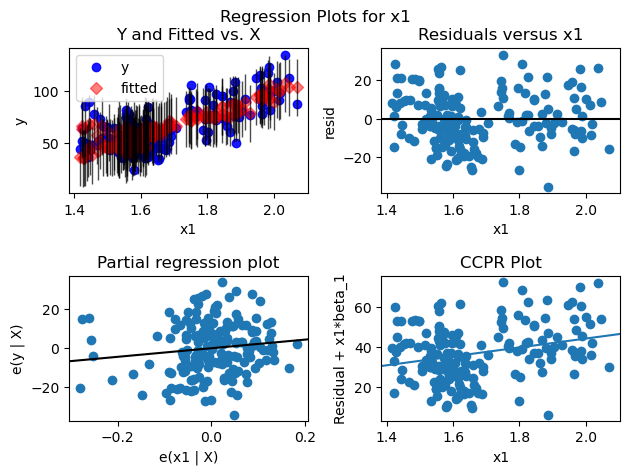

In [51]:
fig_before1 = sm.graphics.plot_regress_exog(multi_model_before, 1)

eval_env: 1


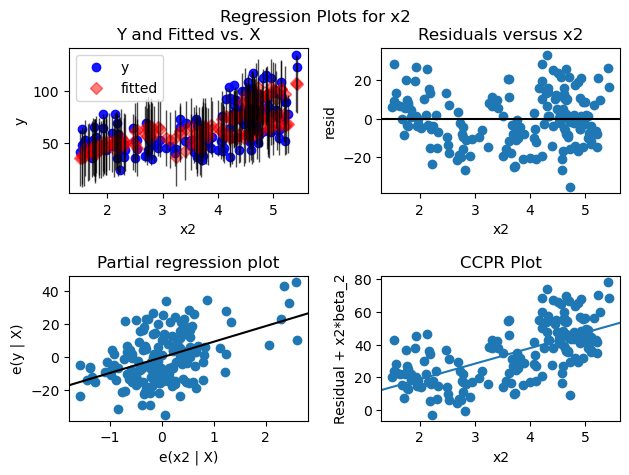

In [52]:
fig_before2 = sm.graphics.plot_regress_exog(multi_model_before, 2)

eval_env: 1


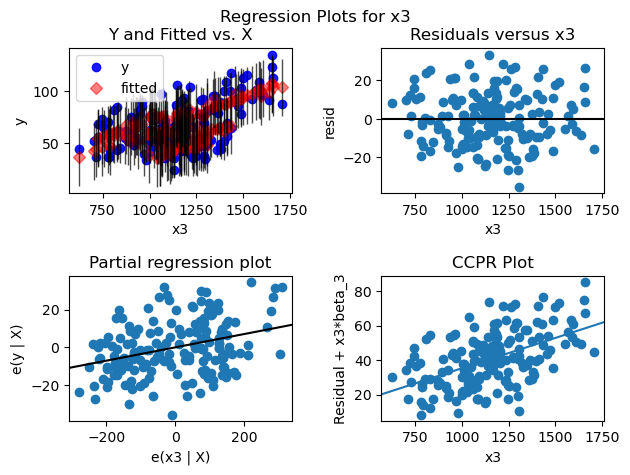

In [53]:
fig_before3 = sm.graphics.plot_regress_exog(multi_model_before, 3)

In [54]:
print(multi_model_before.summary(xname=['Constant', 'Spot_Rate', 'Interest_Rate', 'SMI']))
# ['EXUSUK', 'Interest_Rate', 'SMI']

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     91.05
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           4.19e-35
Time:                        16:34:08   Log-Likelihood:                -694.33
No. Observations:                 173   AIC:                             1397.
Df Residuals:                     169   BIC:                             1409.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -47.2305     12.210     -3.868

In [55]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""

name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 3.9835635374341605),
 ('p-value', 0.26324444946050507),
 ('f-value', 1.327725381658329),
 ('f p-value', 0.26707283180438235)]

In [56]:
VIF = [variance_inflation_factor(multi_model_before.model.exog, i) for i in range(1,4)]
VIF_data = pd.DataFrame(VIF, columns=['VIF'])
VIF_data.index = ['EXUSUK', 'Interest_Rate', 'SMI']
VIF_data

,VIF
EXUSUK,4.470705
Interest_Rate,2.662402
SMI,2.821100


## Regressing on observations after announcement of Brexit

In [57]:
multi_model_after = sm.OLS(Y_test, X_test).fit()
multi_model_after.summary(xname=['Constant', 'Spot_Rate', 'Interest_Rate', 'SMI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     6.239
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           0.000902
Time:                        16:34:20   Log-Likelihood:                -248.80
No. Observations:                  66   AIC:                             505.6
Df Residuals:                      62   BIC:                             514.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -63.3874     34.201     -1.853      0.069    -131.754       4.979
Spot_Rate        63.0748     29.620      2.129      0.037       3.866     122.284
Interest_Rate     5.3354      5.086      1.049      0.298      -4.832      15.503
SMI               0.0206      0.022      0.944      0.349      -0.023       0.064
==============================================================================
Omnibus:                        1.284   Durbin-Watson:                   1.549
Prob(Omnibus):                  0.526   Jarque-Bera (JB):                1.334
Skew:                           0.295   Prob(JB):                        0.513
Kurtosis:                       2.629   Cond. No.                     3.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""

name_after = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_after = sms.het_breuschpagan(multi_model_after.resid, multi_model_after.model.exog)
lzip(name_after, test_after)

[('Lagrange multiplier statistic', 5.122010708214731),
 ('p-value', 0.16307785346498346),
 ('f-value', 1.738803945419645),
 ('f p-value', 0.16828717852609032)]

In [59]:
VIF_after = [variance_inflation_factor(multi_model_after.model.exog, i) for i in range(1,4)]
VIF_data_after = pd.DataFrame(VIF_after, columns=['VIF'])
VIF_data_after.index = ['EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_after

,VIF
EXUSUK,1.296021
Interest_Rate,2.324752
SMI,2.746506


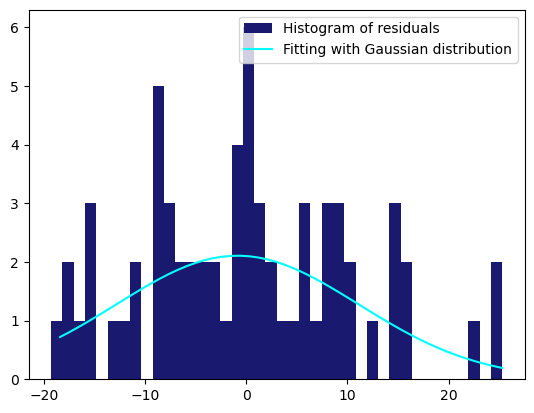

In [60]:
xdata = multi_model_after.resid
ydata, xdata = np.histogram(xdata, bins=50)
xdata = xdata[1:]

def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

params, _ = curve_fit(gauss, xdata, ydata)

fit_y = gauss(xdata, *params)

ax = plt.gca()
ax.hist(multi_model_after.resid, bins=40, color='midnightblue', label='Histogram of residuals')
ax.plot(xdata, fit_y, ls='-', color='aqua', label='Fitting with Gaussian distribution')
ax.legend(loc=0, frameon=True)

eval_env: 1


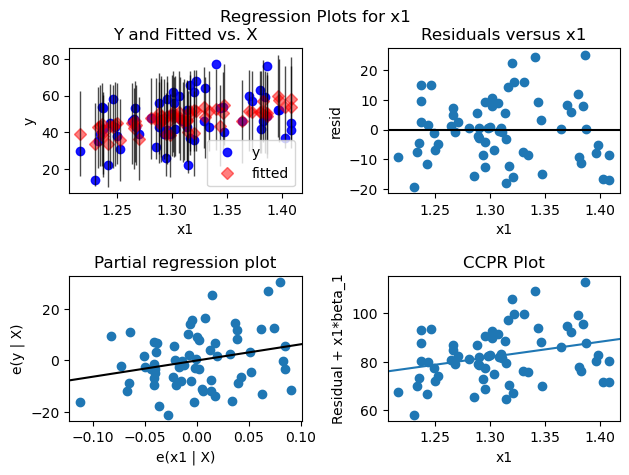

In [61]:
fig_after1 = sm.graphics.plot_regress_exog(multi_model_after, 1)

eval_env: 1


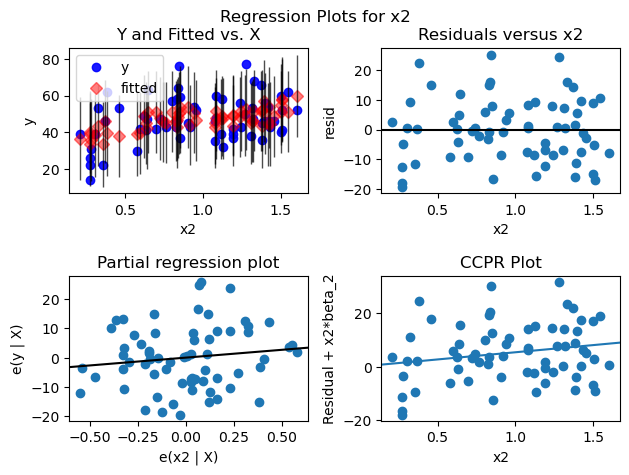

In [62]:
fig_after2 = sm.graphics.plot_regress_exog(multi_model_after, 2)

eval_env: 1


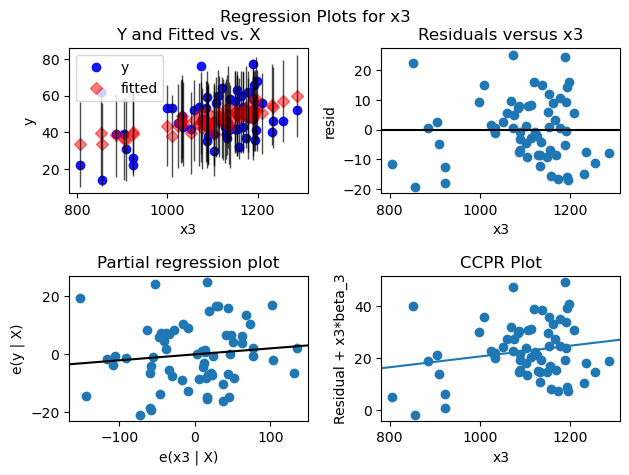

In [63]:
fig_after3 = sm.graphics.plot_regress_exog(multi_model_after, 3)

## Regressing on all observations from 2002 to 2021

In [64]:
X_all, Y_all = df_to_XY(var_monthly, xkeys=x_index, ykeys=y_index)
X_all = sm.add_constant(X_all)
overall_model_ols = sm.OLS(Y_all, X_all).fit()
overall_model_ols.summary(xname=['Constant', 'Spot_Rate', 'Interest_Rate', 'SMI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     145.6
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           2.28e-55
Time:                        16:34:33   Log-Likelihood:                -1107.8
No. Observations:                 264   AIC:                             2224.
Df Residuals:                     260   BIC:                             2238.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant         30.5894      8.781      3.483      0.001      13.298      47.881
Spot_Rate       -57.8823      8.472     -6.832      0.000     -74.564     -41.200
Interest_Rate    15.6060      0.945     16.518      0.000      13.746      17.466
SMI               0.0673      0.007     10.244      0.000       0.054       0.080
==============================================================================
Omnibus:                        8.315   Durbin-Watson:                   1.007
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                9.006
Skew:                           0.326   Prob(JB):                       0.0111
Kurtosis:                       3.627   Cond. No.                     1.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(overall_model_ols.resid, overall_model_ols.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 18.889484953606328),
 ('p-value', 0.0002881670524470207),
 ('f-value', 6.67898191013696),
 ('f p-value', 0.000232611955493981)]

In [66]:
VIF_overall = [variance_inflation_factor(overall_model_ols.model.exog, i) for i in range(1,4)]
VIF_data_over = pd.DataFrame(VIF_overall, columns=['VIF'])
VIF_data_over.index = ['EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_over

,VIF
EXUSUK,3.203854
Interest_Rate,2.407760
SMI,1.647963


eval_env: 1


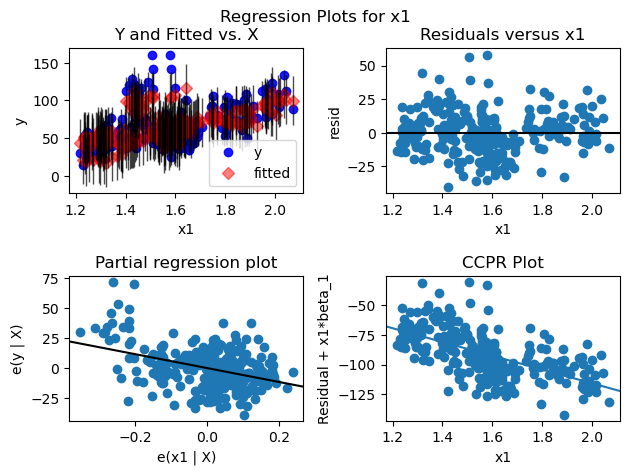

In [67]:
fig_overall1 = sm.graphics.plot_regress_exog(overall_model_ols, 1)

eval_env: 1


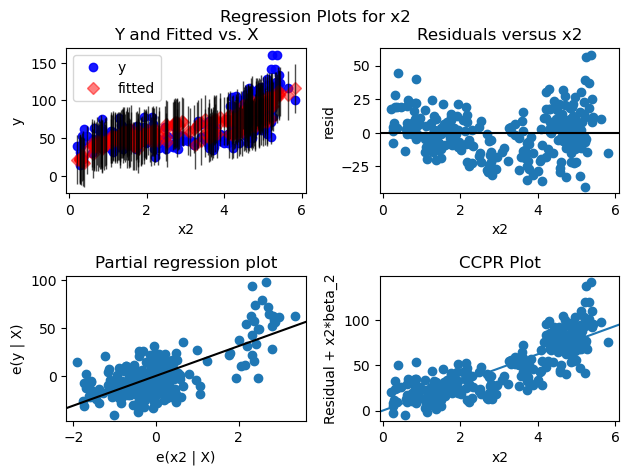

In [68]:
fig_overall2 = sm.graphics.plot_regress_exog(overall_model_ols, 2)

eval_env: 1


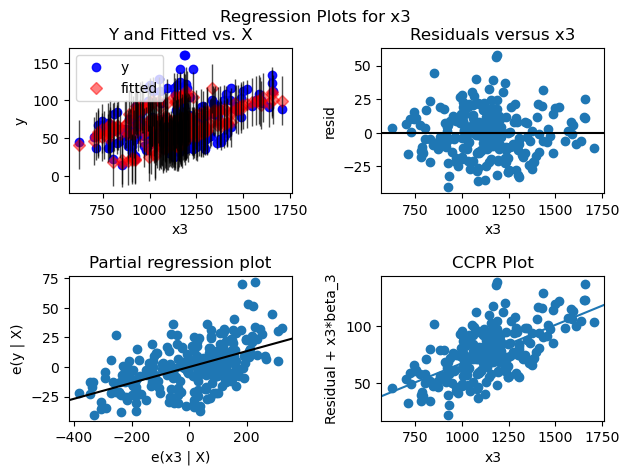

In [69]:
fig_overall3 = sm.graphics.plot_regress_exog(overall_model_ols, 3)

In [70]:
print(overall_model_ols.summary(xname=['Constant', 'Spot_Rate', 'Interest_Rate', 'SMI']))
# ['EXUSUK', 'Interest_Rate', 'SMI']

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     145.6
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           2.28e-55
Time:                        16:34:41   Log-Likelihood:                -1107.8
No. Observations:                 264   AIC:                             2224.
Df Residuals:                     260   BIC:                             2238.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant         30.5894      8.781      3.483

Text(0.5, 0, 'Data')

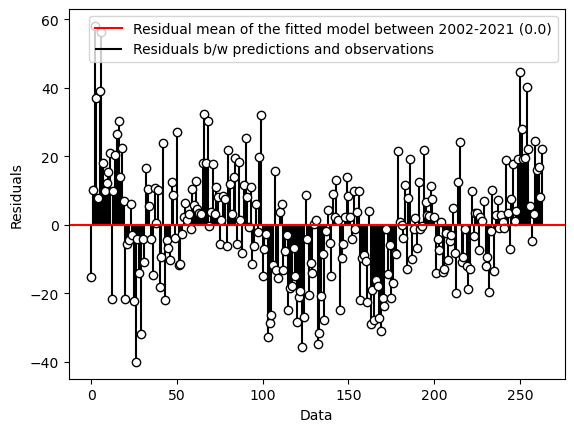

In [74]:
ax = plt.gca()
ax.plot(var_monthly.index, overall_model_ols.resid, ls='', color='k', marker='o', mfc='w', zorder=2)
ax.axhline(overall_model_ols.resid.mean(), ls='-', color='r', label=f'Residual mean of the fitted model between 2002-2021 ({overall_model_ols.resid.mean().round(2)})')
zeros = np.zeros(len(var_monthly.index))
ax.vlines(var_monthly.index, ymin=zeros, ymax=overall_model_ols.resid, colors='k', zorder=1, label=f'Residuals b/w predictions and observations')
ax.legend(loc=0, frameon=True)
ax.set_ylabel('Residuals')
ax.set_xlabel('Data')

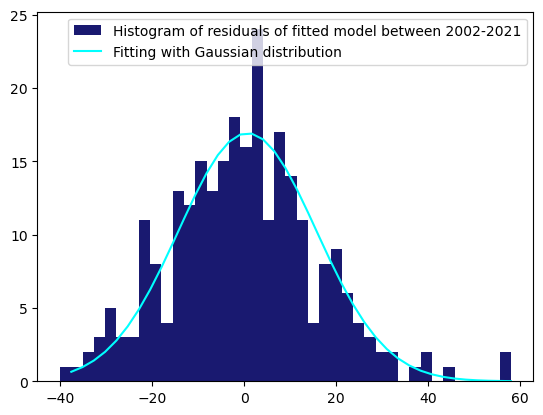

In [75]:
xdata = overall_model_ols.resid
ydata, xdata = np.histogram(xdata, bins=40)
xdata = xdata[1:]

def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

params, _ = curve_fit(gauss, xdata, ydata)

fit_y = gauss(xdata, *params)

ax = plt.gca()
ax.hist(overall_model_ols.resid, bins=40, color='midnightblue', label='Histogram of residuals of fitted model between 2002-2021')
ax.plot(xdata, fit_y, ls='-', color='aqua', label='Fitting with Gaussian distribution')
ax.legend(loc=0, frameon=True)